# 2D Gaussian Mixture Conditioning

This example demonstrates how to fit a Gaussian mixture and condition on one variable to get the distribution of the other.

**What you'll see:**
- 2D data points with fitted mixture contours
- Conditional density `p(y | X=-5)` overlaid as a blue curve
- Conditional density `p(y | X=7)` overlaid as a orange curve


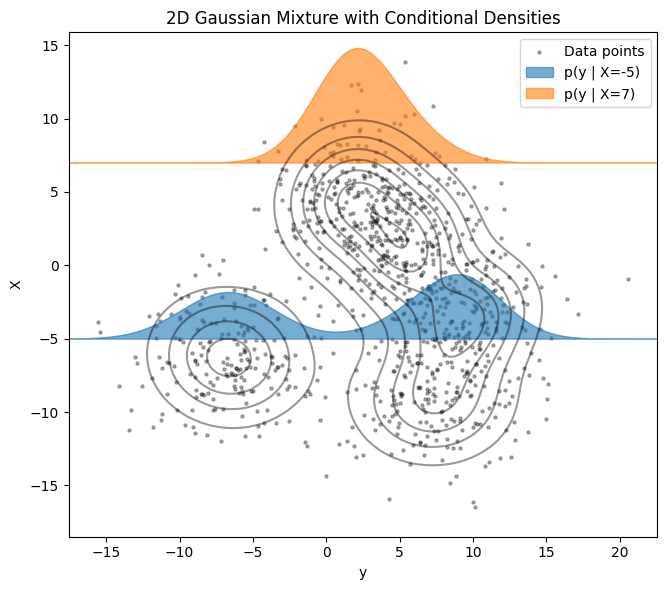

In [1]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  # must be before pyplot import
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from cgmm import GMMConditioner

# Generate 2D data
X, _ = make_blobs(n_samples=1000, centers=5, cluster_std=3, n_features=2, random_state=42)

# Fit Gaussian mixture and create conditioner
gmm = GaussianMixture(n_components=5, random_state=42).fit(X)
conditioner = GMMConditioner(gmm, cond_idx=[0]).precompute()

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data points
ax.scatter(X[:, 1], X[:, 0], s=5, alpha=0.3, c='k', label='Data points')

# Plot mixture contours
x_range = np.linspace(X[:, 0].min()-2, X[:, 0].max()+2, 100)
y_range = np.linspace(X[:, 1].min()-2, X[:, 1].max()+2, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
density = np.exp(gmm.score_samples(grid_points)).reshape(X_grid.shape)
ax.contour(Y_grid, X_grid, density, levels=8, alpha=0.4, colors='black')

for c, x_condition in zip(['C0', 'C1'], [-5, 7]):
    # Condition on X=-5 and plot conditional density
    y_cond = conditioner.condition(x=np.array([x_condition]))
    y_samples = np.linspace(X[:, 1].min()-2, X[:, 1].max()+2, 200)
    y_density = np.exp(y_cond.score_samples(y_samples.reshape(-1, 1)))

    # Overlay conditional density as filled area
    ax.fill_between(y_samples, x_condition, y_density * 60 + x_condition, 
                    alpha=0.6, color=c, label=f'p(y | X={x_condition})')

ax.set_xlabel('y')
ax.set_ylabel('X')
ax.set_title('2D Gaussian Mixture with Conditional Densities')
ax.legend()
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()
